In [1]:
# auto reload libraries (you do need to re-import libraries if you make changes)
%load_ext autoreload
%autoreload 2

# base 
import pandas as pd
import numpy as np
from pprint import pprint
import os

# preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer,KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import QuantileTransformer
# variable importance
from sklearn.inspection import permutation_importance

# models
from sklearn.linear_model import ElasticNet

# visualize
import matplotlib.pyplot as plt
import seaborn as sns

# own defined functions/classes 
from preprocessing.preprocess_pipe import MakeLowerCase
from preprocessing.preprocess_pipe import HdResolutionCategorizer
from preprocessing.preprocess_pipe import StorageCategorizer
from preprocessing.preprocess_pipe import SsdCategorizer

from preprocessing.preprocess_pipe import print_missing
from preprocessing.preprocess_pipe import calculate_perf
from preprocessing.preprocess_pipe import custom_scoring_func_single_p

from modelling.weight_samples import weights_samples

from postprocessing.postprocessing import plot_predictions_results
from postprocessing.postprocessing import plot_residuals

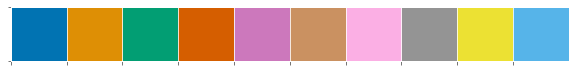

In [2]:
# global parameters
pd.set_option('display.max_columns', 500)
# interactive plotting
#%matplotlib widget
# run grid search
RUN_GRID_SEARCH = True
# style for plotting
plt.style.use('ggplot')
current_palette = sns.color_palette("colorblind")
sns.palplot(current_palette)
sns.set_palette("colorblind")
# figure quality
DPI = 500

# Step 1: import data and split in train and validation set
The validation set is more our own kind of test set

In [3]:
# read in trainig and validation data
df_all_train = pd.read_csv("../../../data/train.csv", sep=',')
df_test = pd.read_csv("../../../data/test.csv", sep=',')

print(f'Dimensions of all training data {df_all_train.shape}')
print(f'Dimension test data {df_test.shape}')

Dimensions of all training data (510, 22)
Dimension test data (222, 20)


In [4]:
# split in training and validation set
df_train = df_all_train.sample(frac=0.75, random_state=0, replace=False)
df_val = df_all_train.drop(df_train.index)

# reset index, if you don't resit missing rows get inserted in the pipeline
# see: https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
df_train = df_train.reset_index().drop('index',axis=1)
df_val = df_val.reset_index().drop('index',axis=1)

# Step 2: define pipeline

In [5]:
#Numerical features to pass down the numerical pipeline 
numerical_features = ['screen_size' ,'pixels_x','pixels_y',
                      'ram', 'weight','ssd','storage']

#Categrical features to pass down the categorical pipeline 
categorical_features = ['brand','base_name', 'screen_surface','touchscreen',
                        'cpu','cpu_details','detachable_keyboard',
                        'discrete_gpu','gpu', 'os','os_details']

# define all unique features
features = np.unique(numerical_features).tolist() + np.unique(categorical_features).tolist()

# target variables
target = ['min_price','max_price']

In [6]:
# train
X_train = df_train[features]
y_train = df_train[target]

# validation (this is kind our own test set)
X_val  = df_val[features]
y_val = df_val[target]

# train_validation (this is all training data we have) for fitting the model
X_all_train = df_all_train[features]
y_all_train = df_all_train[target]

# test
X_test = df_test[features]

In [7]:
# you can add many more and 
# you can even define custom preprocessing steps like 'MakeLowerCase()'

# pipeline  uses only numerical features,
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #('imputer', KNNImputer(n_neighbors=5, weights='uniform',metric='nan_euclidean')),
    ('imputer', IterativeImputer(missing_values=np.nan, random_state=0, n_nearest_features=None, sample_posterior=True)),
    ('transformation', PowerTransformer(method='yeo-johnson',standardize=False)),
    #('quantile_trans', QuantileTransformer(output_distribution='normal', random_state=0)),
    #('scaler1', RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10.0, 90.0))),
    #('poly', PolynomialFeatures(5)),
    #Scale features using statistics that are robust to outliers.
    ('scaler2', RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10.0, 90.0)))])
    #('scaler', StandardScaler())])
    #('scaler', MinMaxScaler())])

# pipeline use only categorical features
categorical_transformer = Pipeline(steps=[ 
    ('lowercase', MakeLowerCase()), # lower cases all columns containing strings
    #('sd_category' ,SsdCategorizer(drop_original_feature=True)),
    #('storage_category', StorageCategorizer(drop_original_feature=True)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    # ('scaler', MaxAbsScaler()),
    #('poly', PolynomialFeatures(2))])

# add both preprocessing pipelines in one pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
# this is how the preporcessed pipeline looks like (just to have an idea)
pd.DataFrame(preprocessor.fit_transform(X_train)).shape

(382, 1)

# Step 3: add models to pipeline

Possible to fit multiple target variabels, so you **don't** need to fit a different models for min. price and max. price

### A) Training and parameter tuning

##### 1) Automatic tuning via grid search

I will only **do the tuning for the minimum price** and use the found parameters also for the maximum price

In [9]:
# define model: I just add some default parameters but you could
# also just write: RandomForestRegressor() since we will perform a grid search 
# to find good hyperparameter values
model_min_p = ElasticNet(random_state=0, max_iter = 200, normalize=True, fit_intercept=False)
model_max_p = ElasticNet(random_state=0, max_iter = 200, normalize=True, fit_intercept=False)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model_min_p.get_params())

# add to pipeline
# 1) min price
pipeline_min_p = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_min_p)])


# add transformation on the target variable, by default power transformation 
# also performs standardization after performing the power transformation
# and back transform to the original space when outputting predictions 

# 1) min price
transformer_target = PowerTransformer(method='box-cox',standardize=False)
scale_target = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10.0, 90.0))
pipeline_y = Pipeline(memory=None,
              steps=[('transformer', transformer_target)])

pipeline_min_p_update = TransformedTargetRegressor(regressor=pipeline_min_p, 
                                         transformer=pipeline_y)

Parameters currently in use:

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': False,
 'l1_ratio': 0.5,
 'max_iter': 200,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}


In [10]:
# alpha float, optional
# Constant that multiplies the penalty terms. 
# Defaults to 1.0. See the notes for the exact mathematical meaning of this parameter. 
# alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object. 
# For numerical reasons, using alpha = 0 with the Lasso object is not advised. Given this, 
# you should use the LinearRegression object.
alpha = np.linspace(0, 20, num=100)

# l1_ratio float
# The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. 
# For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
# For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.

# For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
# For 0 < l1_ratio < 1, the penalty is a combination of 
# L1 and L2 This parameter can be a list, in which case the different values are tested by cross-validation 
# and the one giving the best prediction score is used. Note that a good choice of list of values for l1_ratio is often 
# to put more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge), as in [.1, .5, .7, .9, .95, .99, 1]


l1_ratio = np.linspace(0, 1, num=100)

# Create the random grid
random_grid = {
   'regressor__regressor__alpha': alpha,
   'regressor__regressor__l1_ratio': l1_ratio
    
}

In [11]:
# define random search (and narrow down time grid search)
if RUN_GRID_SEARCH:
    min_p_random_search = RandomizedSearchCV(
       estimator = pipeline_min_p_update, 
       param_distributions = random_grid, n_iter = 200,
       cv = 5, verbose=2, random_state=1, n_jobs = -1, refit=True,
       scoring=make_scorer(custom_scoring_func_single_p, greater_is_better=False)
    )

    # run grid search and refit with best hyper parameters
    weights_train_min_p =  weights_samples(df=y_train.iloc[:,0], order=0, plot_weights=False)
    min_p_random_search.fit(X_train, y_train.iloc[:,0])  
    print(min_p_random_search.best_params_)    
    print(min_p_random_search.best_score_)

# have look at the best hyperparameters and their respective performance (maybe also look at the sd)
pd.DataFrame(min_p_random_search.cv_results_).sort_values(
        by=['mean_test_score'],ascending=False).head(5)

Sum weights: 1.0
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished


{'regressor__regressor__l1_ratio': 0.30303030303030304, 'regressor__regressor__alpha': 0.20202020202020202}
-261.00560214876236


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__regressor__l1_ratio,param_regressor__regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.239594,0.015457,0.021396,0.008421,0.30303,0.20202,{'regressor__regressor__l1_ratio': 0.303030303...,-345.245854,-230.413593,-283.766904,-244.710207,-200.891453,-261.005602,49.859039,1
60,0.297409,0.017298,0.026801,0.009836,0.868687,0.40404,{'regressor__regressor__l1_ratio': 0.868686868...,-402.400207,-299.380809,-356.326768,-311.861277,-245.774930,-323.148798,53.029434,2
70,0.293799,0.020019,0.026193,0.009363,0.545455,0.40404,{'regressor__regressor__l1_ratio': 0.545454545...,-427.694921,-306.311097,-356.336161,-321.529719,-257.717403,-333.917860,56.601814,3
90,0.444923,0.071899,0.039372,0.014981,0.222222,0.40404,{'regressor__regressor__l1_ratio': 0.222222222...,-441.254843,-309.636637,-369.054526,-333.081792,-274.589853,-345.523530,56.907723,4
91,0.388040,0.033737,0.036374,0.009309,0.181818,0.40404,{'regressor__regressor__l1_ratio': 0.181818181...,-442.637977,-308.736590,-370.322072,-334.705873,-276.763181,-346.633139,56.988268,5


##### 2) Manual parameters tuning

In [12]:
# train your final model on all data with best parameters 

# 1) min price
model_min_p = ElasticNet(
    random_state=0, 
    max_iter = 200,
    l1_ratio = 0.30303030303030304,
    alpha = 0.2020
)

# 2)  min price
model_max_p = ElasticNet(
    random_state=0, 
    max_iter = 200,
    l1_ratio = 0.30303030303030304,
    alpha = 0.2020
)


# add to pipeline

# 1) min price
pipeline_min_p = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_min_p)],
              verbose=True)

# 2) min price
pipeline_max_p = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_max_p)],
              verbose=True)

# again add transformer for target variable

# 1) min price
pipeline_min_p_update = TransformedTargetRegressor(regressor=pipeline_min_p, 
                                         transformer=pipeline_y)
# 2) max price
pipeline_max_p_update = TransformedTargetRegressor(regressor=pipeline_max_p, 
                                         transformer=pipeline_y)

# fit final model on all training data we have at hand

# 1) min price
weights_train_min_p = weights_samples(y_train.iloc[:,0], order=0)
pipeline_min_p_update.fit(X_train, y_train.iloc[:,0])

# 2) max price
weights_train_max_p = weights_samples(y_train.iloc[:,1], order=0)
pipeline_max_p_update.fit(X_train, y_train.iloc[:,1])

Sum weights: 1.0
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
Sum weights: 1.0
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('preprocessor',
                                                      ColumnTransformer(n_jobs=None,
                                                                        remainder='drop',
                                                                        sparse_threshold=0.3,
                                                                        transformer_weights=None,
                                                                        transformers=[('num',
                                                                                       Pipeline(memory=None,
                                                                                                steps=[('imputer',
                                                                                                        Itera

In [13]:
# performance on data where the model was fit one (should be very low)
pred_train_min_p = pipeline_min_p_update.predict(X_train)
pred_train_max_p = pipeline_max_p_update.predict(X_train)

# calculate performance
pred_train = pd.DataFrame([pred_train_min_p,pred_train_max_p]).T
calculate_perf(y_train, pred_train)

{'minimum price': 201.95037714064682,
 'maximum price': 212.19164965340184,
 'total error': 414.14202679404866}

##### Performance on validation data

In [14]:
# performance on validation data
pred_val_min_p = pipeline_min_p_update.predict(X_val)
pred_val_max_p = pipeline_max_p_update.predict(X_val)

# calculate performance 
pred_val = pd.DataFrame([pred_val_min_p,pred_val_max_p]).T
calculate_perf(y_val, pred_val)

{'minimum price': 157.4557474069972,
 'maximum price': 157.77307942283818,
 'total error': 315.2288268298354}

In [15]:
# save predictions on validation data
# submission format
submission_format_validation = pd.DataFrame.from_dict(
 {'ID':df_val['id'].values,
 'MIN':pred_val_min_p,
 'MAX':pred_val_max_p}).set_index('ID')

# write to csv
submission_format_validation.to_csv('output/validation/elastic_net.csv' ,
                            header=True, index=True, sep=',')

### C) Post processing

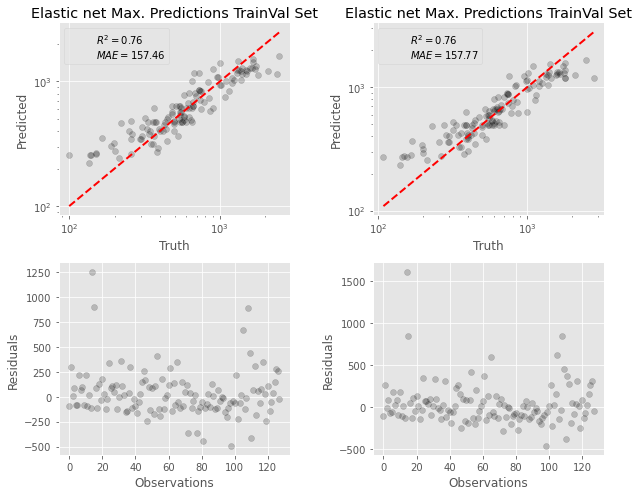

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

# fitted against true predictions minimum price
plot_predictions_results(ax=axs[0], 
                        y_true=y_val.iloc[:,0], 
                        y_pred=pred_val_min_p, 
                        title="Elastic net Max. Predictions TrainVal Set", 
                        log_scale=True)

# fitted against true predictions maximum price
plot_predictions_results(ax=axs[1], 
                        y_true=y_val.iloc[:,1], 
                        y_pred=pred_val_max_p, 
                        title="Elastic net Max. Predictions TrainVal Set", 
                        log_scale=True)

# residuals minimum price
plot_residuals(ax=axs[2], 
               y_true=y_val.iloc[:,0], 
               y_pred=pred_val_min_p, 
               title="", 
               log_scale=False,
               order=1)

# residuals maximum price
plot_residuals(ax=axs[3], 
               y_true=y_val.iloc[:,1], 
               y_pred=pred_val_max_p, 
               title="", 
               log_scale=False,
               order=1)
fig.tight_layout()

plt.savefig('output/figures/elastic_net/fig1.png', dpi=DPI)

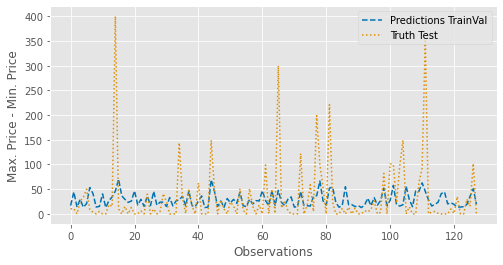

In [17]:
plt.figure(figsize=(8,4))
plt.plot(pred_val_max_p - pred_val_min_p, label="Predictions TrainVal", linestyle="--")
plt.plot(y_val.iloc[:,1] - y_val.iloc[:,0], label="Truth Test", linestyle=':')
plt.xlabel("Observations")
plt.ylabel("Max. Price - Min. Price")
plt.legend(loc="upper right");
plt.savefig('output/figures/elastic_net/fig2.png', dpi=DPI)

In [18]:
vip_val_min_p = permutation_importance(pipeline_min_p_update, X_val, y_val.iloc[:,0], n_repeats=10,
                                random_state=1, n_jobs=3)

vip_val_max_p = permutation_importance(pipeline_min_p_update, X_val, y_val.iloc[:,1], n_repeats=10,
                                random_state=1, n_jobs=3)

sorted_idx_min_p = vip_val_min_p.importances_mean.argsort()
sorted_idx_max_p = vip_val_max_p.importances_mean.argsort()

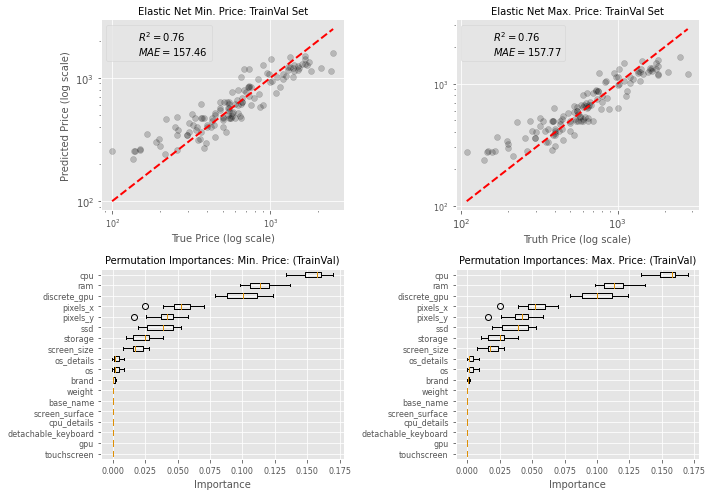

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = np.ravel(ax)

# minimum price
plot_predictions_results(ax=ax[0], 
                        y_true=y_val.iloc[:,0], 
                        y_pred=pred_val_min_p, 
                        title="", 
                        log_scale=True)
ax[0].set_title("Elastic Net Min. Price: TrainVal Set", fontsize=10)
ax[0].set_xlabel("True Price (log scale)", size=10)
ax[0].set_ylabel("Predicted Price (log scale)", size=10)
ax[0].xaxis.set_tick_params(labelsize=8)



# maximum price
plot_predictions_results(ax=ax[1], 
                        y_true=y_val.iloc[:,1], 
                        y_pred=pred_val_max_p, 
                        title="", 
                        log_scale=True)
ax[1].set_title("Elastic Net Max. Price: TrainVal Set", fontsize=10)
ax[1].set_xlabel("Truth Price (log scale)", size=10)
ax[1].set_ylabel("", size=10)
ax[1].yaxis.set_tick_params(labelsize=8)


# minimum price
ax[2].boxplot(vip_val_min_p.importances[sorted_idx_min_p].T,
           vert=False, labels=X_val.columns[sorted_idx_min_p])
ax[2].set_title("Permutation Importances: Min. Price: (TrainVal)", fontsize=10)
ax[2].set_xlabel("Importance", size=10)
ax[2].xaxis.set_tick_params(labelsize=8)
ax[2].yaxis.set_tick_params(labelsize=8)

# maximum price
ax[3].boxplot(vip_val_min_p.importances[sorted_idx_max_p].T,
           vert=False, labels=X_val.columns[sorted_idx_max_p])
ax[3].set_title("Permutation Importances: Max. Price: (TrainVal)", fontsize=10)
ax[3].set_xlabel("Importance", size=10)
ax[3].xaxis.set_tick_params(labelsize=8)
ax[3].yaxis.set_tick_params(labelsize=8)


fig.tight_layout()
plt.savefig('output/figures/elastic_net/fig3.png', dpi=DPI)

### D) Predictions test data

In [20]:
# train your final model on all data with best parameters 

# 1) min price
model_min_p_final = ElasticNet(
    random_state=0, 
    max_iter = 200,
    l1_ratio = 0.30303030303030304,
    alpha = 0.2020
)

# 2)  min price
model_max_p_final = ElasticNet(
       random_state=0, 
    max_iter = 200,
    l1_ratio = 0.30303030303030304,
    alpha = 0.2020
)


# add to pipeline

# 1) min price
pipeline_min_p_final = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_min_p_final)],
              verbose=True)

# 2) min price
pipeline_max_p_final = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_max_p_final)],
              verbose=True)

# again add transformer for target variable

# 1) min price
pipeline_min_p_final = TransformedTargetRegressor(regressor=pipeline_min_p_final, 
                                         transformer=pipeline_y)
# 2) max price
pipeline_max_p_final = TransformedTargetRegressor(regressor=pipeline_max_p_final, 
                                         transformer=pipeline_y)

# fit final model on all training data we have at hand

# 1) min price
weights_all_train_min_p = weights_samples(y_all_train.iloc[:,0], order=2)
pipeline_min_p_final.fit(X_train, y_train.iloc[:,0])

# 2) max price
weights_all_train_max_p = weights_samples(y_train.iloc[:,1], order=2)
pipeline_max_p_final.fit(X_train, y_train.iloc[:,1])

Sum weights: 1.0
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
Sum weights: 1.0
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('preprocessor',
                                                      ColumnTransformer(n_jobs=None,
                                                                        remainder='drop',
                                                                        sparse_threshold=0.3,
                                                                        transformer_weights=None,
                                                                        transformers=[('num',
                                                                                       Pipeline(memory=None,
                                                                                                steps=[('imputer',
                                                                                                        Itera

In [21]:
# performance on all data where the model was fit one (should be very low)
pred_all_train_min_p = pipeline_min_p_final.predict(X_all_train)
pred_all_train_max_p = pipeline_max_p_final.predict(X_all_train)

# calculate performance 
pred_all_train = pd.DataFrame([pred_all_train_min_p, pred_all_train_max_p]).T
calculate_perf(y_all_train, pred_all_train)

{'minimum price': 190.78309752122104,
 'maximum price': 198.53365555631922,
 'total error': 389.3167530775403}

In [22]:
# make predictions on test data
pred_test_min_p = pipeline_min_p_final.predict(X_test)
pred_test_max_p = pipeline_max_p_final.predict(X_test)

# submission format
submission_format = pd.DataFrame.from_dict(
 {'ID':df_test['id'].values,
 'MIN':pred_test_min_p,
 'MAX':pred_test_max_p}).set_index('ID')

# write to csv
submission_format.to_csv('output/submission/elastic_net.csv' ,
                            header=True, index=True, sep=',')